In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [27]:
result = pd.read_csv('Dataset_modelo_csv.csv')

In [3]:
result.columns

Index(['property_id', 'lon', 'lat', 'fips_code', 'is_new_construction',
       'is_contingent', 'is_price_reduced', 'is_foreclosure', 'is_plan',
       'is_coming_soon', 'year_built', 'lot_sqft', 'sqft', 'baths', 'garage',
       'stories', 'beds', 'list_price', 'encoded_city', 'encoded_type',
       'central_air', 'laundry_room', 'community_outdoor_space', 'fireplace',
       'dishwasher', 'recreation_facilities', 'central_heat', 'forced_air',
       'shopping', 'hardwood_floors', 'basement', 'family_room', 'view',
       'dining_room', 'washer_dryer', 'community_security_features',
       'community_swimming_pool', 'floor_plan', 'updated_kitchen', 'city_view',
       'swimming_pool', 'pets_allowed', 'park', 'modern_kitchen', 'ensuite',
       'fenced_yard', 'open_floor_plan', 'rental_property', 'corner_lot',
       'community_clubhouse', 'big_lot', 'den_or_office', 'carport',
       'groundscare', 'hill_or_mountain_view', 'spa_or_hot_tub', 'big_yard',
       'farm', 'high_ceiling', '

In [28]:
x = result.drop(columns='list_price')
y = result['list_price']

In [30]:
param_grid = {
    'n_estimators': [ 300],  # Número de árboles en el ensamble
    'learning_rate': [ 0.2],  # Tasa de aprendizaje (learning rate)
    'max_depth': [5],  # Profundidad máxima de los árboles
    'min_child_weight': [ 3],  # Peso mínimo de una hoja
    'gamma': [ 0.1, 0.2],  # Parámetro de penalización para la división de un nodo
    'alpha': [ 3, 5],  # Término de regularización L1
    'lambda': [ 0.1, 0.2],  # Término de regularización L2
}

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [31]:
x_train.shape, x_test.shape

((12070, 69), (3018, 69))

In [8]:
model = XGBRegressor(objective='reg:squarederror')

In [9]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',verbose=1, n_jobs=-1)

In [10]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [3, 5], 'gamma': [0.1, 0.2],
                         'lambda': [0.1, 0.2], 'learning_rate': [0.2],
                         'max_depth': [5], 'min_child_weight': [3],
                         'n_estimators': [300]},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [12]:
best_params

{'alpha': 5,
 'gamma': 0.1,
 'lambda': 0.1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 300}

In [32]:
y_pred = best_model.predict(x_test)

In [33]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 15243288314.862036
Mean Absolute Error: 70583.68356737828


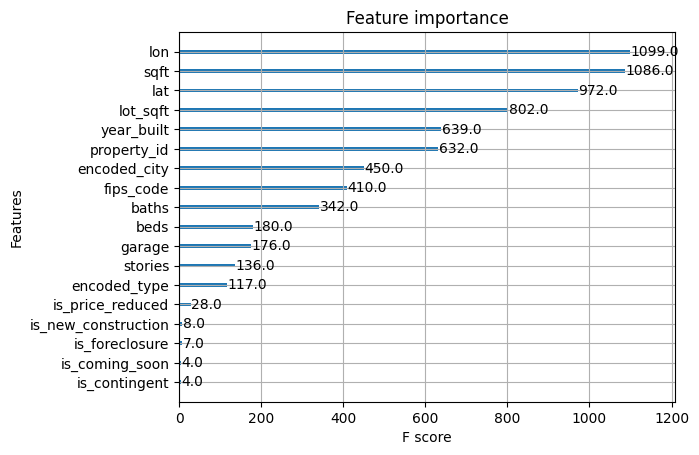

In [34]:
xgb.plot_importance(best_model)
plt.show()

In [55]:
import joblib
modelo_guardado = 'modelo_entrenado_prices.joblib'

joblib.dump(best_model, modelo_guardado)

['modelo_entrenado_prices.joblib']

In [35]:
def error_porcentual(df):
    df = df.copy()
    df['error_porcentual']=0
    for index,row in df.iterrows():
        
        price = row['list_price']
        pred = row['prediction']
        error_porcentual =((abs( price-pred))/price)*100

        df.at[index,'error_porcentual'] = error_porcentual

    return df

In [36]:
df_comparacion = y_test.reset_index()

In [37]:
df_comparacion['prediction'] = y_pred

In [38]:
df_comparacion = error_porcentual(df_comparacion)

In [46]:
df_comparacion.shape

(3018, 4)

In [53]:
df_real =df_comparacion[df_comparacion['list_price'] >= 2000 ]

In [54]:
df_real

,index,list_price,prediction,error_porcentual
0,9218,799900.0,6.323457e+05,20.946907
1,5340,149900.0,1.929384e+05,28.711412
2,13025,465000.0,4.693884e+05,0.943743
3,13465,2500000.0,2.013478e+06,19.460865
4,3766,299900.0,3.749832e+05,25.036075
...,...,...,...,...
3013,12714,1175000.0,8.208441e+05,30.140926
3014,14623,99900.0,1.143654e+05,14.479886
3015,3489,555000.0,5.598852e+05,0.880225
3016,10091,1400000.0,1.172327e+06,16.262384


In [45]:
df_comparacion[df_comparacion['error_porcentual'] <= 20 ]

,index,list_price,prediction,error_porcentual
2,13025,465000.0,4.693884e+05,0.943743
3,13465,2500000.0,2.013478e+06,19.460865
5,316,315000.0,2.617156e+05,16.915675
6,8897,1398000.0,1.449534e+06,3.686302
7,12464,590000.0,5.916310e+05,0.276441
...,...,...,...,...
3012,856,498000.0,4.529845e+05,9.039257
3014,14623,99900.0,1.143654e+05,14.479886
3015,3489,555000.0,5.598852e+05,0.880225
3016,10091,1400000.0,1.172327e+06,16.262384


In [49]:
df_real

,index,list_price,prediction,error_porcentual
0,9218,799900.0,6.323457e+05,20.946907
1,5340,149900.0,1.929384e+05,28.711412
2,13025,465000.0,4.693884e+05,0.943743
3,13465,2500000.0,2.013478e+06,19.460865
4,3766,299900.0,3.749832e+05,25.036075
...,...,...,...,...
3013,12714,1175000.0,8.208441e+05,30.140926
3014,14623,99900.0,1.143654e+05,14.479886
3015,3489,555000.0,5.598852e+05,0.880225
3016,10091,1400000.0,1.172327e+06,16.262384


In [48]:
round(df_real['error_porcentual'].mean(),2)

17.63

In [40]:
round(df_comparacion['error_porcentual'].mean(),2)

39.73

In [60]:
houses_for_sale_modelo = pd.read_csv('..\Dataset limpios\Houses_for_sale_processed_with_pred.csv')

In [61]:
houses_for_sale = pd.read_csv('..\Dataset limpios\Houses_for_sale_processed.csv')

In [62]:
loaded_model = joblib.load('modelo_entrenado_prices.joblib')

In [63]:
x=houses_for_sale_modelo[loaded_model.feature_names_in_]

In [64]:
y = houses_for_sale_modelo['list_price']

In [65]:
prediction = loaded_model.predict(x)

In [58]:
len(prediction)

11139

In [66]:
houses_for_sale['prediction']=prediction

In [67]:
houses_for_sale.head()

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,type,primary_photo,tags,list_date,photos,list_price,listing_id,primary,status,prediction
0,1000163193,-122.340542,37.948990,94804,California,Richmond,CA,2814 Lowell Ave,6013.0,Contra Costa,...,single_family,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,"['central_air', 'community_outdoor_space', 'di...",2023-09-16,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,899000.0,2.959741e+09,True,for_sale,8.297158e+05
1,1000748625,-122.196956,47.918020,98208,Washington,Everett,WA,8729 Del Campo Dr,53061.0,Snohomish,...,single_family,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,"['basement', 'community_outdoor_space', 'dinin...",2023-09-27,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,870000.0,2.960037e+09,True,for_sale,9.260006e+05
2,1001237574,-112.313678,33.763826,85383,Arizona,Peoria,AZ,31010 N 117th Dr,4013.0,Maricopa,...,single_family,https://ap.rdcpix.com/fd492f6878f09cbe6eda231a...,"['community_boat_facilities', 'community_golf'...",2023-09-27,https://ap.rdcpix.com/fd492f6878f09cbe6eda231a...,1899000.0,2.960018e+09,True,for_sale,1.881548e+06
3,1001483948,-117.133291,33.540322,92591,California,Temecula,CA,39920 N General Kearny Rd,6065.0,Riverside,...,single_family,https://ap.rdcpix.com/0487398867f4fdca5c707a75...,"['central_air', 'central_heat', 'city_view', '...",2023-09-26,https://ap.rdcpix.com/0487398867f4fdca5c707a75...,679000.0,2.959985e+09,True,for_sale,9.240058e+05
4,1001489359,-122.206693,37.804517,94602,California,Oakland,CA,2520 Rampart St,6001.0,Alameda,...,single_family,https://ap.rdcpix.com/8926b1a848f534b30828ca98...,"['community_outdoor_space', 'den_or_office', '...",2023-09-26,https://ap.rdcpix.com/8926b1a848f534b30828ca98...,799000.0,2.960011e+09,True,for_sale,7.833759e+05


In [68]:
houses_for_sale.to_csv('..\Dataset limpios\Houses_for_sale_processed_with_pred.csv')

In [56]:
houses_for_sale.index

NameError: name 'houses_for_sale' is not defined